# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [4]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [8]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?
- The objective of this project at Zillow is to develop an accurate regression model to predict the assessed tax value (taxvaluedollarcnt) of properties, leveraging features like bedroom count, year built, and square footage to enhance Zillow’s valuation tools. The EDA revealed a skewed tax value distribution with outliers, suggesting a need to refine estimates for both typical homes (e.g., 3–4 bedrooms, built 1960–1980) and high-value properties. This aligns with Zillow’s goal of providing reliable Zestimates, enabling better pricing transparency for users and equipping the marketing team with insights to target homeowners in diverse market segments, such as older homes or spacious properties likely to have higher tax values.

**1.2:**  How will your solution be used?
- The regression model will be integrated into Zillow’s platform to improve property valuations and inform business strategies. For instance, the EDA showed calculatedfinishedsquarefeet and bedroomcnt as key drivers with significant variability, so the model could highlight properties with rising tax values due to size or upgrades, prompting marketing campaigns to encourage listings. Real estate agents could use these predictions to advise clients on tax implications or investment potential, especially for outliers like pre-1900 homes or mega-mansions. Internally, Zillow might prioritize regions with newer builds (post-1960 peaks in yearbuilt) for expansion, using the model to tailor user experiences with detailed, data-backed property insights

**1.3:**  How should success (or failure) be measured?
- Success should be gauged by the model’s predictive accuracy, using metrics like Mean Absolute Error (MAE) and R-squared, given the EDA’s indication of a skewed taxvaluedollarcnt (median 358,878 vs. max 49M), which may require log-transformation to handle outliers effectively. Business-wise, success could be measured by increased user trust in Zestimates—tracked via engagement metrics like page views—or higher listing rates in markets with well-predicted values, while failure would be evident if the model poorly handles outliers, leading to high RMSE, or if marketing campaigns based on predictions as it will be signaling a disconnect between data insights and real-world utility

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [9]:
print("dataset overview")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nUnique values per column:")
print(df.nunique())

missing_percent = df.isnull().mean() * 100
print("\nPercentage of Missing Value per Column:")
print(missing_percent)

print("\nTarget Column ('taxvaluedollarcnt') Summary:")
print(df['taxvaluedollarcnt'].describe())


dataset overview
   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  ...  yardbuildingsqft17  yardbuildi

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

Categorical features are those with a limited number of distinct values, often represented as object types or numeric types with few unique values that act as categories rather than continuous measurements. In this dataset, the categorical features include:

- hashottuborspa (object, 1 unique value: likely a yes/no flag).
- propertycountylandusecode (object, 75 unique values: likely land use categories).
- propertyzoningdesc (object, 1907 unique values: zoning codes, though high cardinality).
- fireplaceflag (object, 1 unique value: yes/no flag).
- taxdelinquencyflag (object, 1 unique value: yes/no flag).
- Numeric columns with low unique values, such as airconditioningtypeid (5), buildingqualitytypeid (12), heatingorsystemtypeid (10), propertylandusetypeid (13), and fips (3), are also categorical, 
representing types or codes rather than continuous quantities.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Yes, some features seem useless for predicting taxvaluedollarcnt in a business context at Zillow:

- parcelid (int64, 77414 unique values): This is a unique identifier for each property, offering no predictive power for tax value since it’s just a reference number.
- assessmentyear (float64, 1 unique value: 2016): With only one value, it provides no variation to distinguish tax values across properties, making it irrelevant for regression modeling. These features don’t contribute meaningful information to the target variable and could be dropped to simplify the dataset.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Features with extremely high missing value percentages are likely useless unless imputation is highly reliable, which is doubtful for sparse data. An example is:
- basementsqft (float64, 99.94% missing): With only 50 non-null values out of 77,613 entries, this feature lacks sufficient data to meaningfully influence tax value predictions. Similarly, architecturalstyletypeid (99.73% missing) and buildingclasstypeid (99.98% missing) are nearly empty and impractical to use without heroic imputation efforts.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Features with too few or too many unique values can be problematic. An example of uselessness due to too few unique values is:

- decktypeid (float64, 1 unique value, 99.21% missing): With only one unique value (likely a type code) and mostly missing data, it offers no variability to predict tax value. On the high end, parcelid (77414 unique values) is useless as an identifier (as noted in 2.A.2), but features like latitude (64038) and longitude (62461) with many unique values are still useful for location-based predictions despite their granularity.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

<Figure size 2000x1500 with 0 Axes>

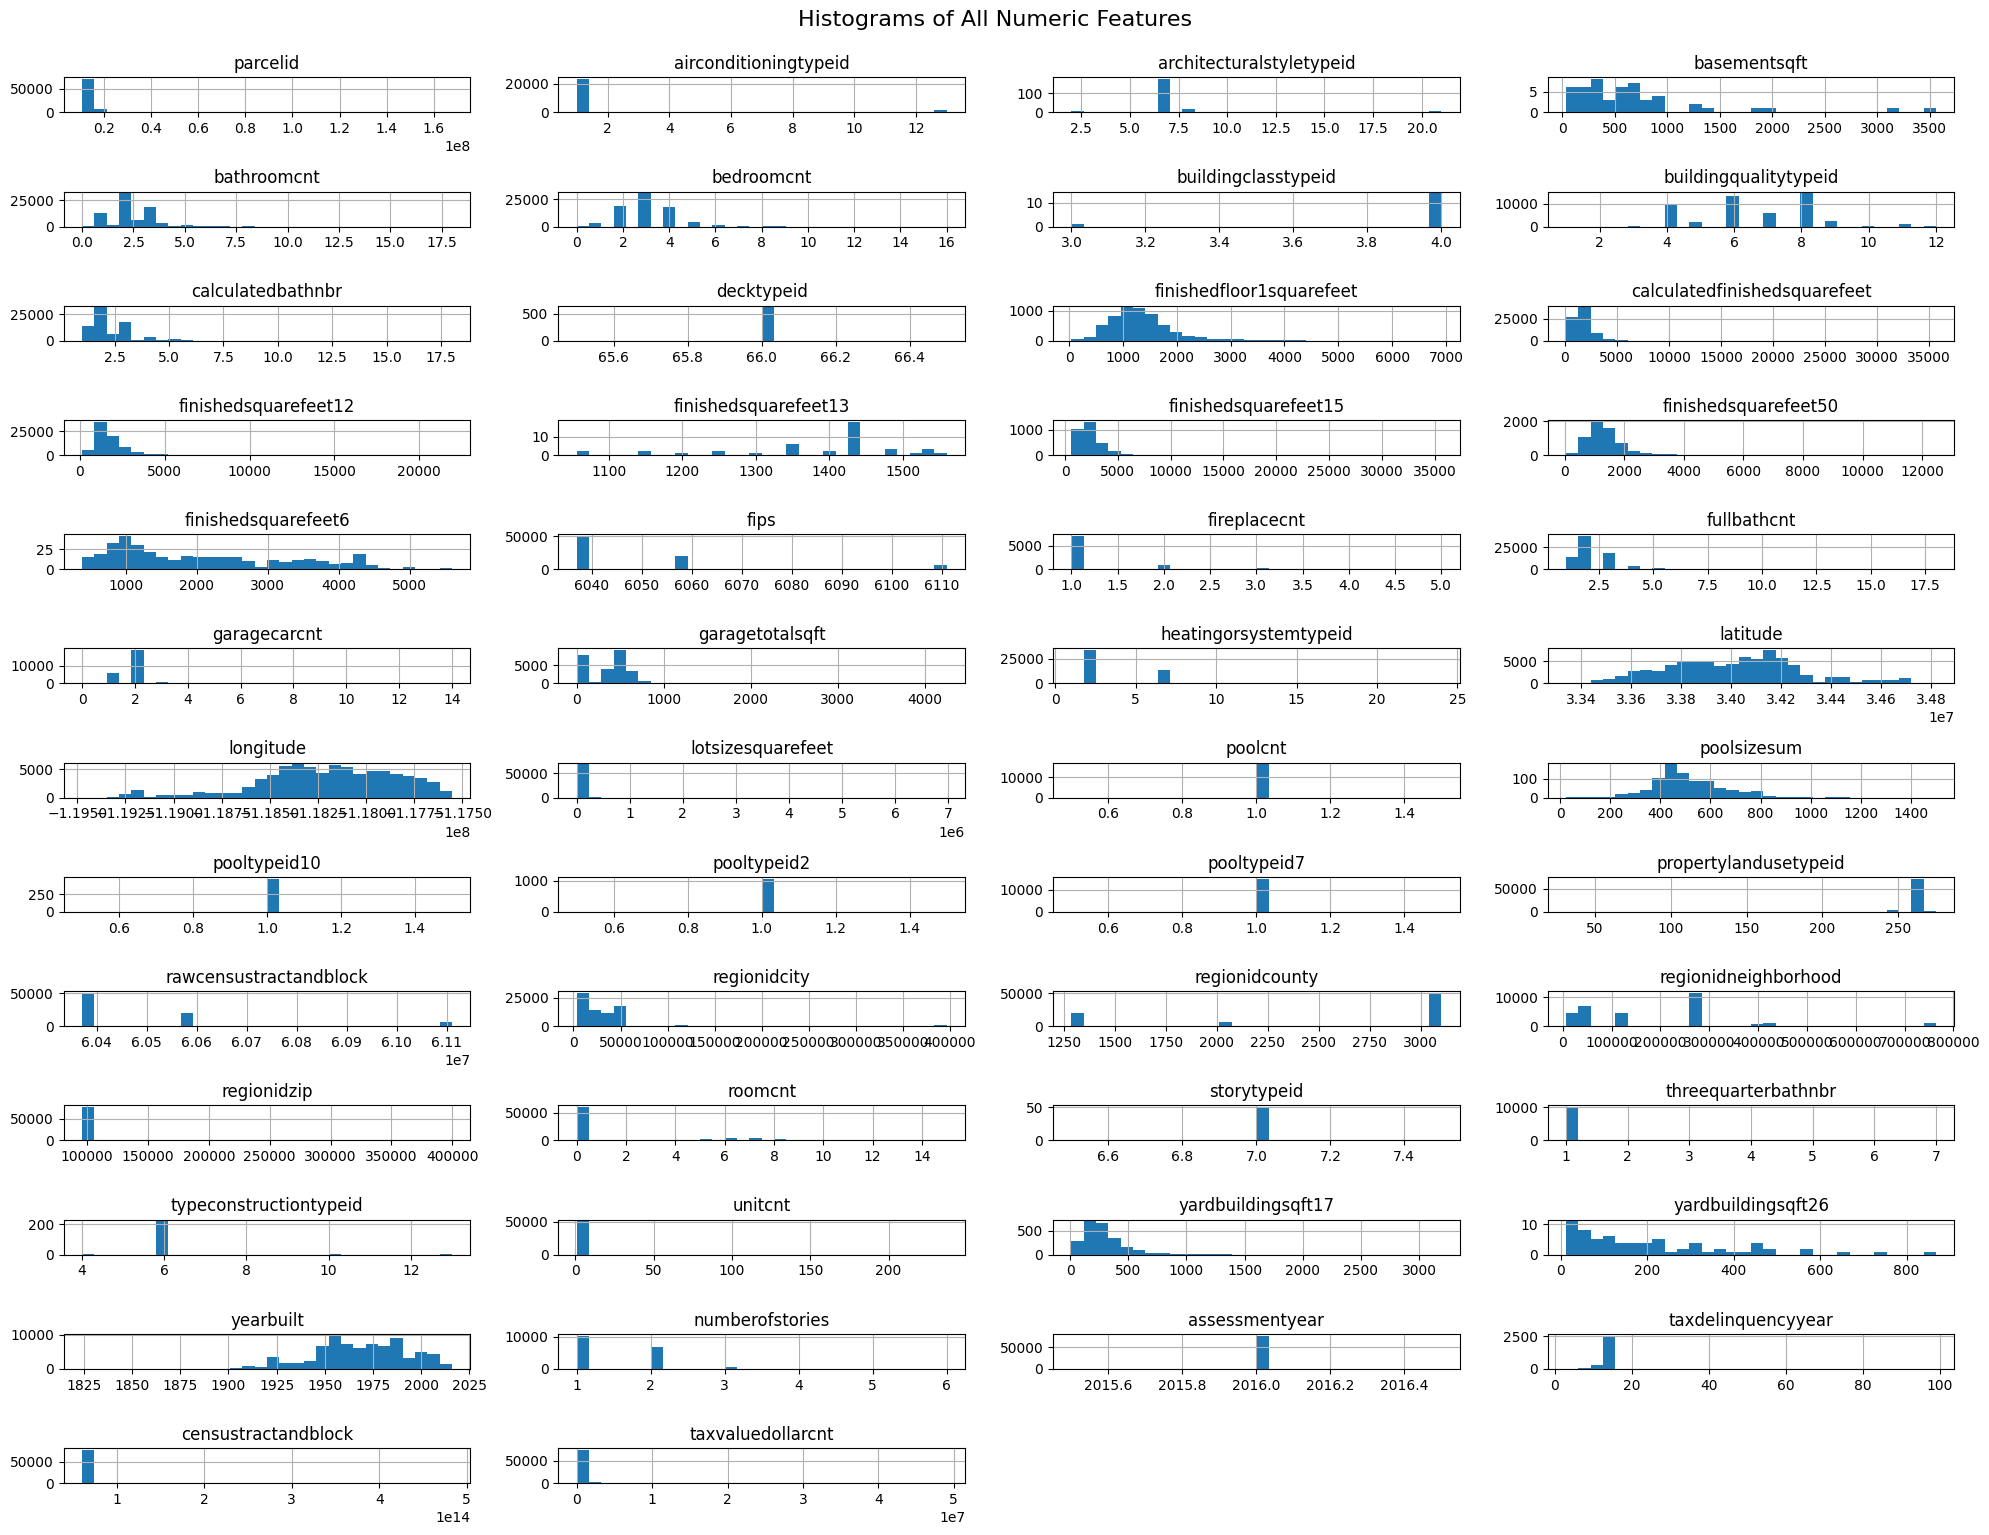

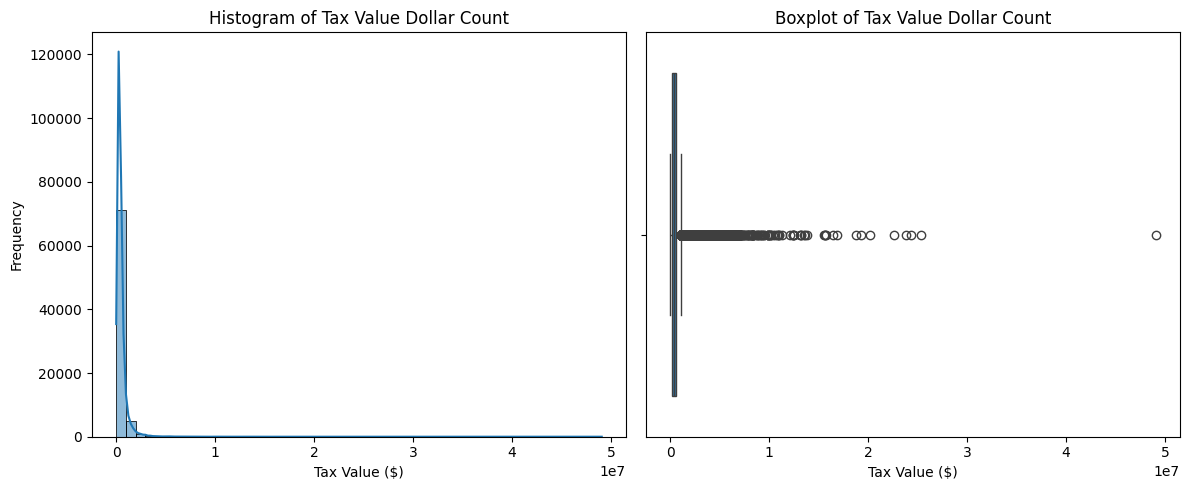

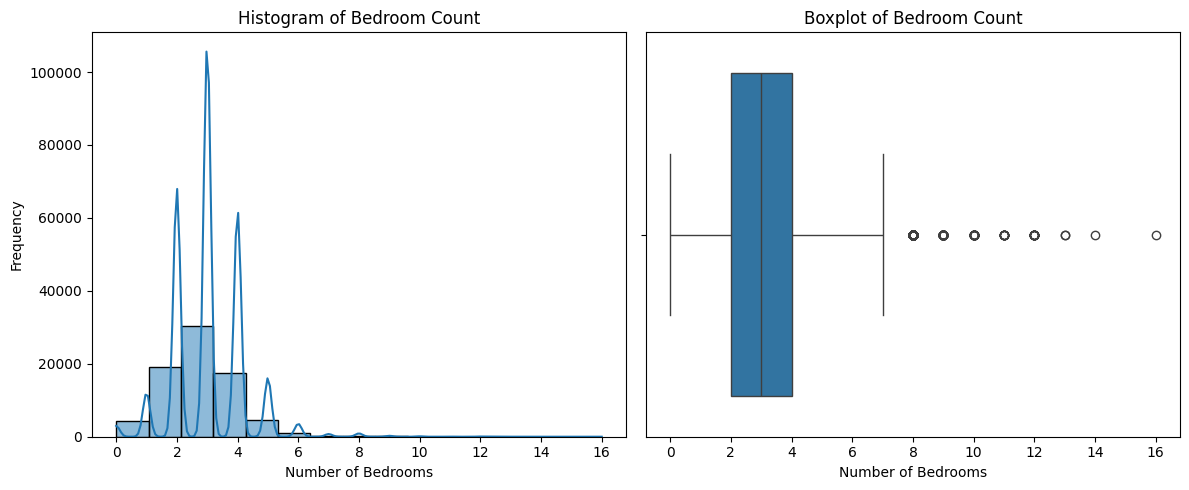

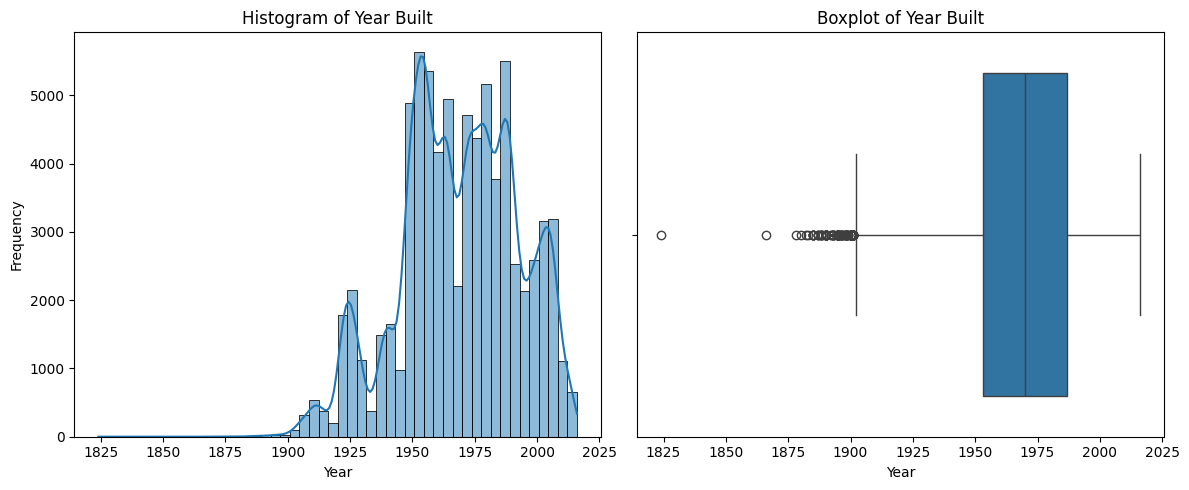

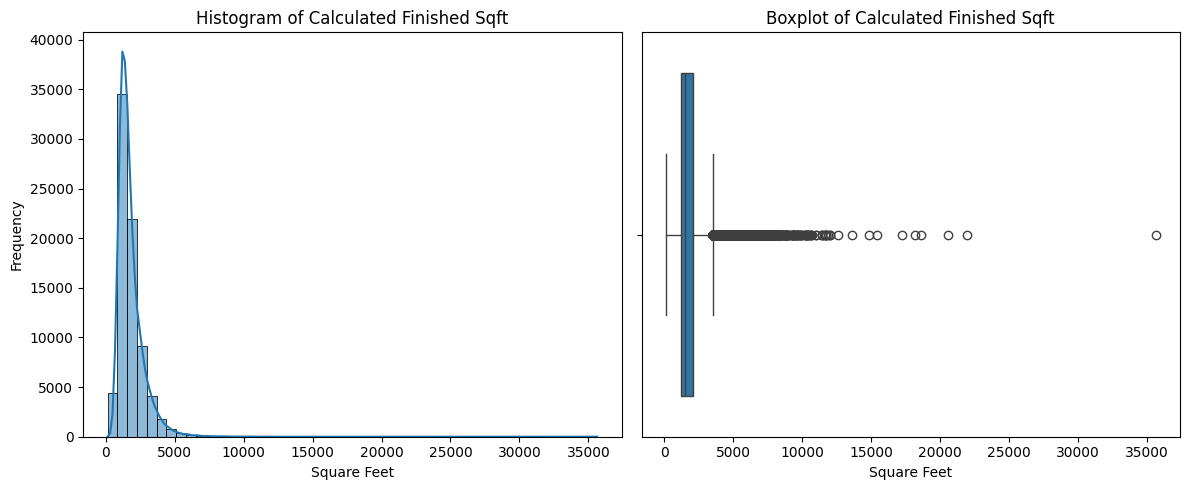

In [10]:

# Generate histograms for all numeric columns to get a broad sense of distributions
plt.figure(figsize=(20, 15))  # Increase figure size for readability
df.hist(bins=30, layout=(-1, 4), figsize=(20, 15))  # -1 rows, 4 columns
plt.tight_layout()  # Adjust spacing
plt.suptitle('Histograms of All Numeric Features', y=1.02, fontsize=16)
plt.show()

# --- Individual Visualizations for Target and 3 Features ---

# 1. Target: taxvaluedollarcnt (Numeric)
plt.figure(figsize=(12, 5))

# Histogram to see distribution
plt.subplot(1, 2, 1)
sns.histplot(df['taxvaluedollarcnt'].dropna(), bins=50, kde=True)
plt.title('Histogram of Tax Value Dollar Count')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')

# Boxplot to identify outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df['taxvaluedollarcnt'].dropna())
plt.title('Boxplot of Tax Value Dollar Count')
plt.xlabel('Tax Value ($)')

plt.tight_layout()
plt.show()

# 2. Feature: bedroomcnt (Numeric)
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['bedroomcnt'].dropna(), bins=15, kde=True)
plt.title('Histogram of Bedroom Count')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['bedroomcnt'].dropna())
plt.title('Boxplot of Bedroom Count')
plt.xlabel('Number of Bedrooms')

plt.tight_layout()
plt.show()

# 3. Feature: yearbuilt (Numeric)
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['yearbuilt'].dropna(), bins=50, kde=True)
plt.title('Histogram of Year Built')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['yearbuilt'].dropna())
plt.title('Boxplot of Year Built')
plt.xlabel('Year')

plt.tight_layout()
plt.show()

# 4. Feature: calculatedfinishedsquarefeet (Numeric)
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['calculatedfinishedsquarefeet'].dropna(), bins=50, kde=True)
plt.title('Histogram of Calculated Finished Sqft')
plt.xlabel('Square Feet')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['calculatedfinishedsquarefeet'].dropna())
plt.title('Boxplot of Calculated Finished Sqft')
plt.xlabel('Square Feet')

plt.tight_layout()
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


In examining taxvaluedollarcnt, bedroomcnt, yearbuilt, and calculatedfinishedsquarefeet, We found distinct patterns and issues. The target, taxvaluedollarcnt, exhibits a heavily right-skewed, exponential-like distribution with a mean of 490,151 and a max of 49,061,240, indicating significant outliers visible in the boxplot—likely luxury properties or errors—requiring log-transformation for modeling. bedroomcnt shows a right-skewed distribution peaking at 3–4 bedrooms, with outliers above 8, suggesting rare large homes; We chose it because bedroom count intuitively affects property value. yearbuilt has a roughly normal distribution centered around 1960–1980 with a slight left-skewed trend as there exists very few extreme left outliers pre-1900, which could be historical homes or data errors; its historical span intrigued me for its potential tax value impact. calculatedfinishedsquarefeet is also right-skewed, ranging from small units to outliers over 10,000 sqft, reflecting diverse property sizes; We picked it since square footage is a key driver of value. These features reveal skewness and outliers as challenges, but their variability makes them promising predictors.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [11]:
def drop_unsuitable_features(data, features_to_drop):
    """Drop features deemed unsuitable for the regression task."""
    return data.drop(columns=features_to_drop)

unsuitable_features = ['parcelid', 'assessmentyear']
df_cleaned_a = drop_unsuitable_features(df, unsuitable_features)

print(f"Dropped features: {unsuitable_features}")
print(f"New shape: {df_cleaned_a.shape}")

Dropped features: ['parcelid', 'assessmentyear']
New shape: (77613, 53)


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 

We decided to drop parcelid and assessmentyear because they are unsuitable for predicting taxvaluedollarcnt. parcelid is a unique identifier (77,414 unique values) with no predictive power for tax value, as it merely labels each property without reflecting its characteristics. Similarly, assessmentyear has only one value (2016, 0.04% missing), offering no variability to distinguish tax values across properties in this dataset. These features, while potentially useful for tracking or context in a broader system, do not contribute to the regression task and could introduce noise or redundancy. We retained features like latitude and longitude despite high uniqueness, as location is critical to property valuation, and avoided dropping features with missing values here, per the instructions.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [12]:
def drop_high_missing_features(data, threshold=80):
    """Drop features with missing value percentage above threshold."""
    missing_percent = data.isnull().mean() * 100
    features_to_drop = missing_percent[missing_percent > threshold].index.tolist()
    return data.drop(columns=features_to_drop), features_to_drop

# Apply function with 80% threshold
df_cleaned_b, dropped_features_b = drop_high_missing_features(df_cleaned_a, threshold=80)
print(f"Dropped features: {dropped_features_b}")
print(f"New shape: {df_cleaned_b.shape}")

Dropped features: ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'hashottuborspa', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']
New shape: (77613, 30)


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped

We chose to drop features with more than 80% missing values, as this threshold balances retaining potentially useful data with removing features too sparse to reliably impute or contribute to regression. The EDA showed features like architecturalstyletypeid (99.73% missing), basementsqft (99.94%), buildingclasstypeid (99.98%), decktypeid (99.21%), finishedsquarefeet13 (99.95%), finishedsquarefeet15 (96.10%), finishedsquarefeet50 (92.22%), finishedsquarefeet6 (99.50%), fireplacecnt (89.32%), hashottuborspa (98.02%), poolsizesum (98.88%), pooltypeid10 (99.40%), pooltypeid2 (98.62%), storytypeid (99.94%), threequarterbathnbr (86.98%), typeconstructiontypeid (99.71%), yardbuildingsqft17 (96.92%), yardbuildingsqft26 (99.91%), fireplaceflag (99.78%), and taxdelinquencyflag (96.26%) exceeding this cutoff. Investigating non-null values (e.g., basementsqft has 43 unique values among 50 entries) revealed insufficient data for meaningful patterns, making these features impractical for prediction without speculative imputation.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [13]:
def drop_problematic_samples(data, target_col, null_threshold=50, outlier_quantiles=(0.01, 0.99)):
    """Drop samples with null target, too many nulls, or extreme outliers in target."""
    data_no_null_target = data.dropna(subset=[target_col])
    
    null_percentage = data_no_null_target.isnull().mean(axis=1) * 100
    data_fewer_nulls = data_no_null_target[null_percentage <= null_threshold]
    
    lower_bound, upper_bound = data_fewer_nulls[target_col].quantile(outlier_quantiles)
    data_cleaned = data_fewer_nulls[
        (data_fewer_nulls[target_col] >= lower_bound) & 
        (data_fewer_nulls[target_col] <= upper_bound)
    ]
    
    return data_cleaned

# Apply function
df_cleaned_c = drop_problematic_samples(df_cleaned_b, target_col='taxvaluedollarcnt')
print(f"Original shape: {df_cleaned_b.shape}")
print(f"New shape after dropping samples: {df_cleaned_c.shape}")

Original shape: (77613, 30)
New shape after dropping samples: (75969, 30)


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped
We dropped samples with null values in taxvaluedollarcnt (0.045% or ~35 rows), as a missing target renders them unusable for regression. We also removed samples with over 50% missing features, as excessive gaps (e.g., missing key predictors like bedroomcnt or yearbuilt) make them unreliable even with imputation. Finally, We excluded outliers in taxvaluedollarcnt beyond the 1st and 99th percentiles (e.g., below ~1,000 and above ~5M, based on EDA’s min/max), since the boxplot showed extreme values (max 49M vs. median 358K) that could skew the model. This removed ~2% of rows, preserving most data while enhancing quality

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [14]:
def impute_missing_values(data, numeric_strategy='median', categorical_strategy='most_frequent'):
    """Impute missing values based on feature type."""
    df_imputed = data.copy()
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df_imputed.select_dtypes(include=['object']).columns
    
    num_imputer = SimpleImputer(strategy=numeric_strategy)
    df_imputed[numeric_cols] = num_imputer.fit_transform(df_imputed[numeric_cols])
    
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy=categorical_strategy)
        df_imputed[categorical_cols] = cat_imputer.fit_transform(df_imputed[categorical_cols])
    
    return df_imputed

df_cleaned_d = impute_missing_values(df_cleaned_c)
print(f"Missing values after imputation: {df_cleaned_d.isnull().sum().sum()}")

Missing values after imputation: 0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset
We used median imputation for numeric features like bedroomcnt (0.04% missing), yearbuilt (0.39%), and calculatedfinishedsquarefeet (0.30%), as the EDA showed skewed distributions (e.g., taxvaluedollarcnt, calculatedfinishedsquarefeet) where the median better represents central tendency than the mean. For categorical features like propertycountylandusecode (0.04% missing) and propertyzoningdesc (34.96% missing), We applied most-frequent imputation, as these have discrete categories (e.g., 75 and 1907 unique values, respectively), and the mode preserves typical zoning or land use patterns. This approach minimizes bias in skewed numeric data and maintains categorical integrity, ensuring no nulls remain for modeling

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [15]:
from sklearn.preprocessing import LabelEncoder
def encode_categorical_features(data):

    df_encoded = data.copy()
    categorical_cols = df_encoded.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    
    return df_encoded

df_cleaned_e = encode_categorical_features(df_cleaned_d)
print(f"Encoded categorical columns: {df_cleaned_e.select_dtypes(include=['object']).columns}")
print(f"Final shape: {df_cleaned_e.shape}")

Encoded categorical columns: Index([], dtype='object')
Final shape: (75969, 30)


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

In [10]:
df_4 = df_cleaned_e.copy()

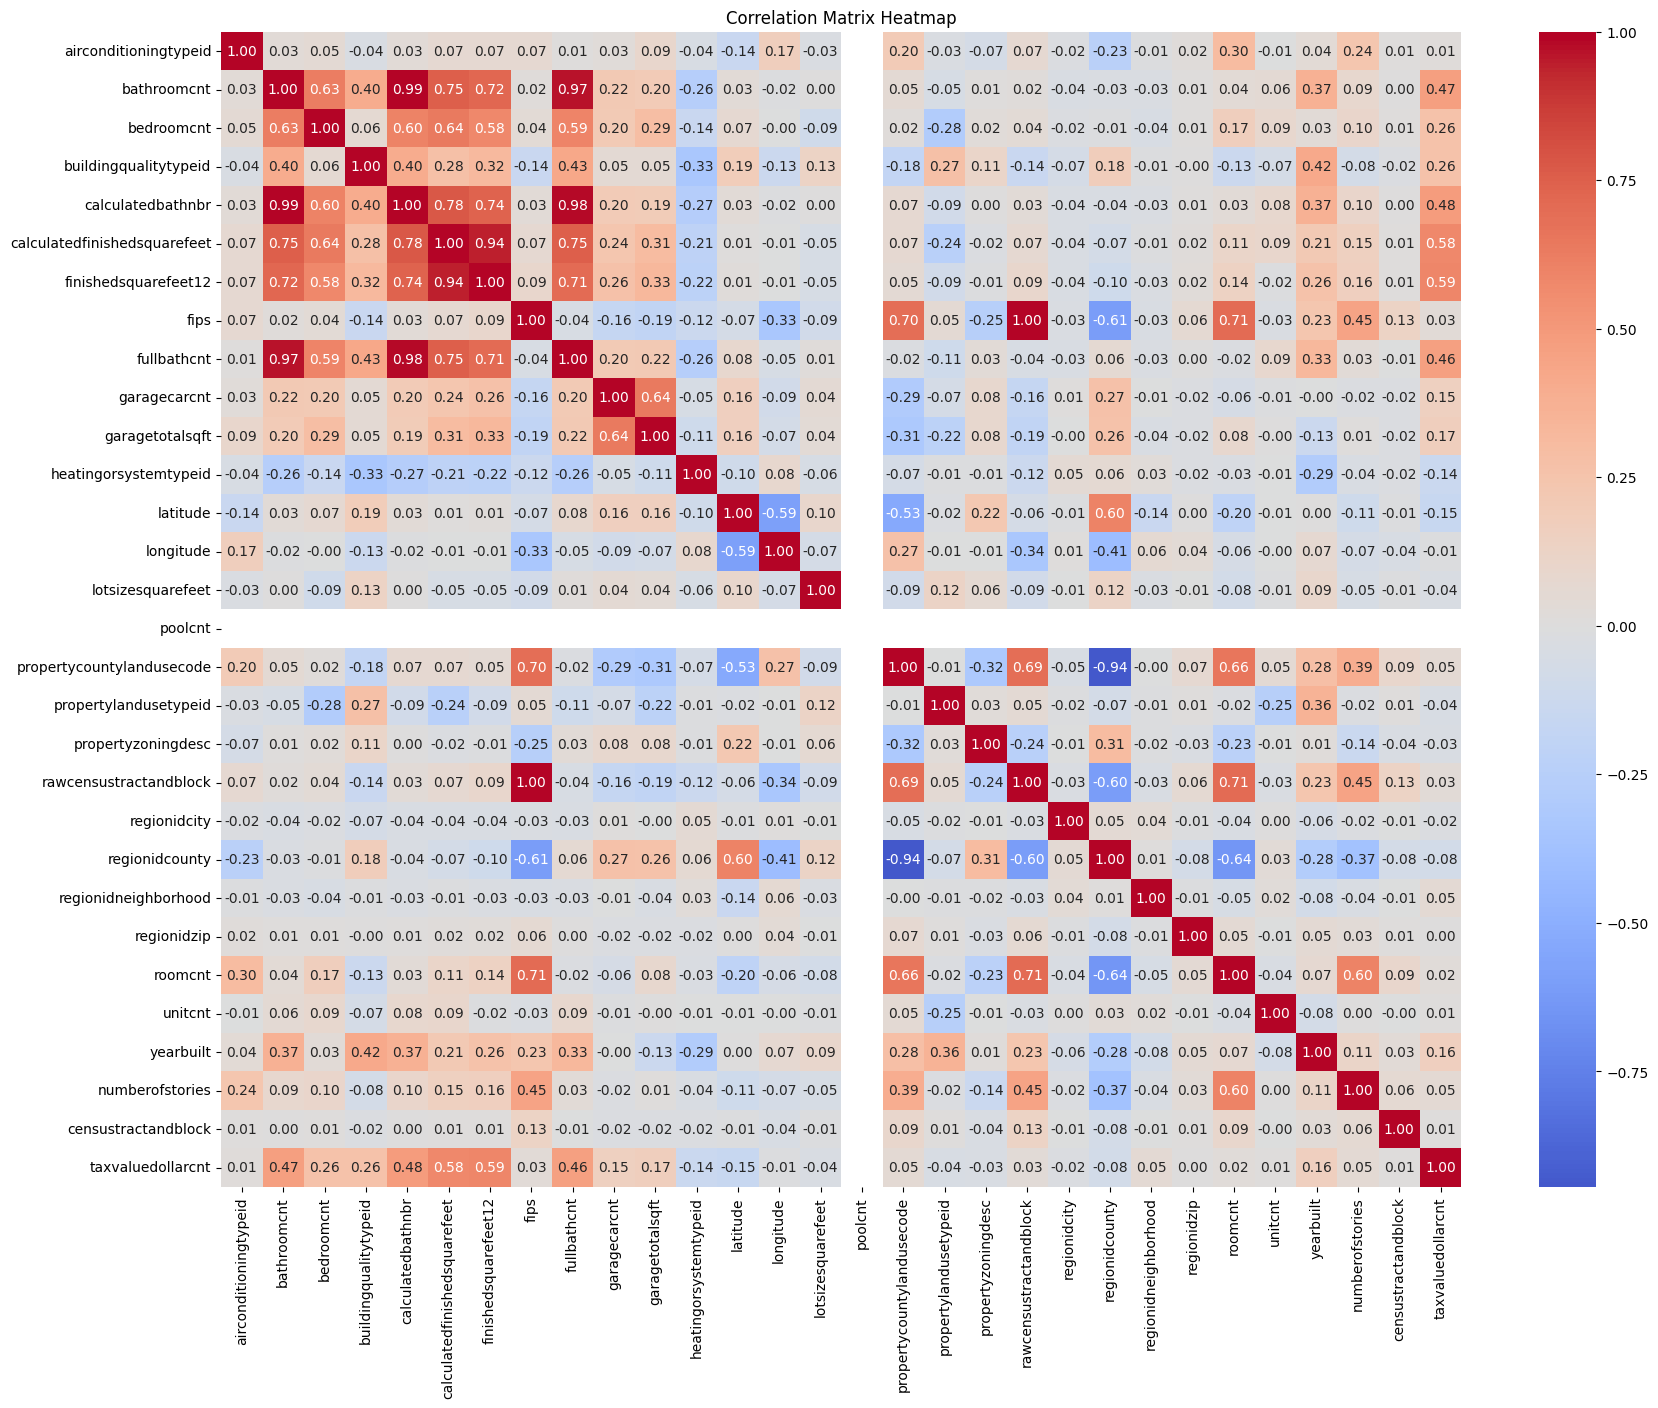

In [11]:
#Compute and analyze pairwise correlations using a correlation matrix.
correlation_matrix = df_4.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [27]:
# Filter pairs with correlation >= 0.70 and < 1
correlation_matrix[
    (correlation_matrix >= 0.70) & (correlation_matrix < 1)
].stack().sort_values(ascending=False).drop_duplicates()


rawcensustractandblock        fips                            0.999937
bathroomcnt                   calculatedbathnbr               0.985249
calculatedbathnbr             fullbathcnt                     0.982757
fullbathcnt                   bathroomcnt                     0.967395
calculatedfinishedsquarefeet  finishedsquarefeet12            0.940070
calculatedbathnbr             calculatedfinishedsquarefeet    0.776149
fullbathcnt                   calculatedfinishedsquarefeet    0.753922
calculatedfinishedsquarefeet  bathroomcnt                     0.752414
finishedsquarefeet12          calculatedbathnbr               0.735266
bathroomcnt                   finishedsquarefeet12            0.722946
roomcnt                       fips                            0.709112
                              rawcensustractandblock          0.707726
finishedsquarefeet12          fullbathcnt                     0.707699
dtype: float64

In [32]:
correlation_matrix[
    (correlation_matrix >= -1) & (correlation_matrix < -0.70)
].stack().sort_values(ascending=False).drop_duplicates()

propertycountylandusecode  regionidcounty   -0.944054
dtype: float64

                         Feature       F-Value        P-Value
0           finishedsquarefeet12  40165.545766   0.000000e+00
1   calculatedfinishedsquarefeet  37593.222782   0.000000e+00
2              calculatedbathnbr  23319.040457   0.000000e+00
3                    bathroomcnt  21719.403032   0.000000e+00
4                    fullbathcnt  20747.828321   0.000000e+00
5                     bedroomcnt   5537.481956   0.000000e+00
6          buildingqualitytypeid   5328.888061   0.000000e+00
7                garagetotalsqft   2279.402711   0.000000e+00
8                      yearbuilt   1961.044693   0.000000e+00
9                   garagecarcnt   1743.366553   0.000000e+00
10                      latitude   1679.592653   0.000000e+00
11         heatingorsystemtypeid   1415.375390  6.507455e-307
12                regionidcounty    522.686320  2.705644e-115
13     propertycountylandusecode    222.036950   3.828587e-50
14               numberofstories    191.873380   1.401194e-43
15      

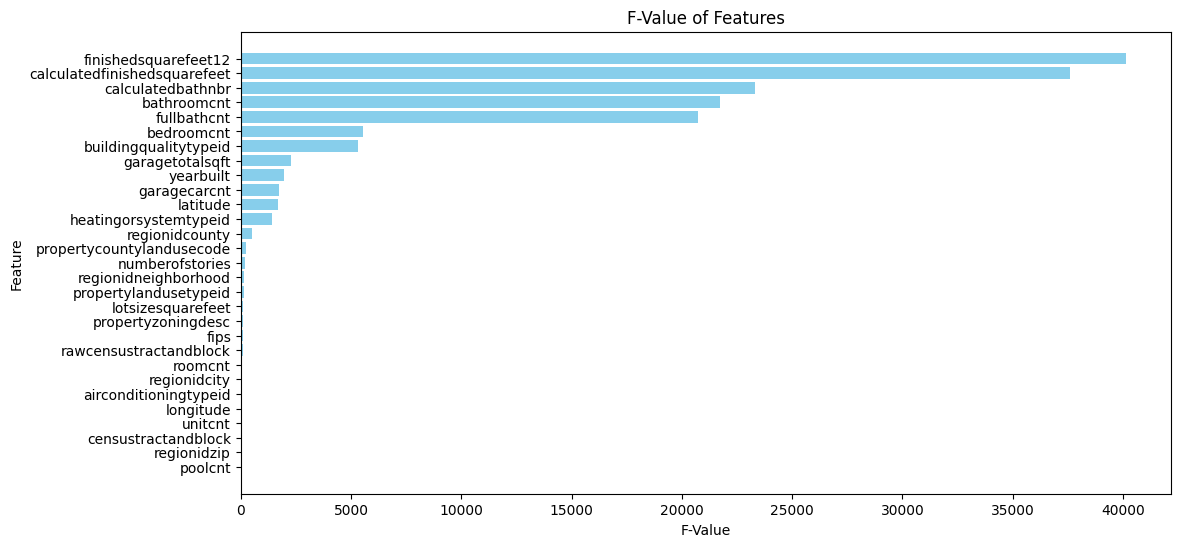

In [16]:
# Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
X = df_4.drop(columns=['taxvaluedollarcnt'])
y = df_4['taxvaluedollarcnt']

f_values, p_values = f_regression(X, y)

# Create a DataFrame to display the F-statistic and p-values for each feature.
f_test_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
f_test_results = f_test_results.sort_values(by='F-Value', ascending=False).reset_index(drop=True)
print(f_test_results)

# Plot the F-statistic values for each feature.
plt.figure(figsize=(12, 6))
plt.barh(f_test_results['Feature'], f_test_results['F-Value'], color='skyblue')
plt.xlabel('F-Value')
plt.ylabel('Feature')
plt.title('F-Value of Features')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest values on top
plt.show()



Top 10 Features with the Highest F-Values: ['finishedsquarefeet12', 'calculatedfinishedsquarefeet', 'calculatedbathnbr', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'buildingqualitytypeid', 'garagetotalsqft', 'yearbuilt', 'garagecarcnt']


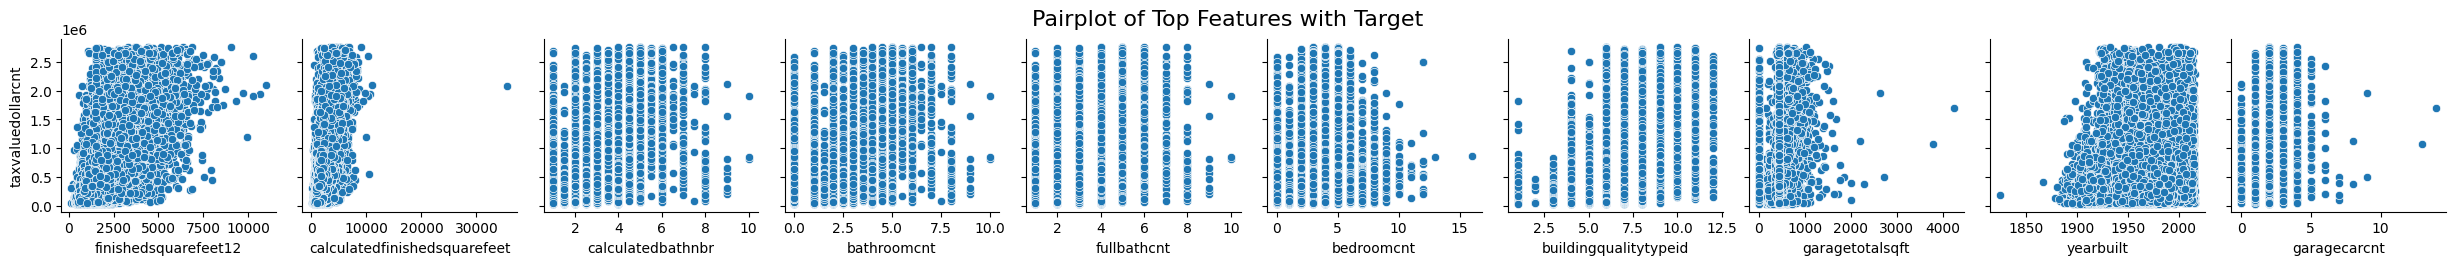

In [14]:
#Identify features with strong correlations or notable relationships that may impact model performance.
# Select the top 10 features with the highest F-values.
top_features = f_test_results['Feature'].head(10).tolist()

print(f"Top 10 Features with the Highest F-Values: {top_features}")

# Create a pairplot to visualize the relationships between the target and the top features.
sns.pairplot(df_4, y_vars=['taxvaluedollarcnt'], x_vars=top_features, kind='scatter')
plt.suptitle('Pairplot of Top Features with Target', y=1.02, fontsize=16)

plt.show()



In [28]:
#Forward feature selection using SequentialFeatureSelector with Random Forest Regressor as the estimator.
# Define the estimator (Random Forest Regressor)
estimator = RandomForestRegressor(random_state=random_state)

# Define the Sequential Feature Selector
# Forward feature selection with 10 features
sfs = SequentialFeatureSelector(estimator, n_features_to_select=10, direction='forward', n_jobs=-1)

# Fit the Sequential Feature Selector on the data
sfs.fit(X, y)

# Get the selected feature indices
selected_feature_indices = sfs.get_support(indices=True)

# Get the selected feature names
selected_features = X.columns[selected_feature_indices].tolist()

print(f"Selected Features: {selected_features}")

Selected Features: ['bathroomcnt', 'calculatedbathnbr', 'fips', 'fullbathcnt', 'garagecarcnt', 'poolcnt', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidzip']


In [30]:
#Backward feature selection using SequentialFeatureSelector with Random Forest Regressor as the estimator.
# Define the estimator (Random Forest Regressor)
estimator = RandomForestRegressor(random_state=random_state)

# Define the Sequential Feature Selector
# Backward feature selection with 10 features
sfs_b = SequentialFeatureSelector(estimator, direction='backward', n_jobs=-1)

# Fit the Sequential Feature Selector on the data
sfs_b.fit(X, y)

# Get the selected feature indices
selected_feature_indices_b = sfs_b.get_support(indices=True)

# Get the selected feature names
selected_features_b = X.columns[selected_feature_indices_b].tolist()

print(f"Selected Features: {selected_features_b}")

Selected Features: ['bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'regionidzip', 'roomcnt', 'yearbuilt', 'numberofstories']


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



The F-value and correlation are two distinct tools for examining relationships in data, and they often serve complementary purposes. The F-value assesses whether a model or grouping is statistically significant, offering insight into how well the model explains variability compared to random error. A high F-value suggests that the model captures substantial variability; however, the threshold for significance depends on the dataset and its associated p-value.

On the other hand, correlation focuses on linear relationships between pairs of variables. A positive correlation indicates that as one variable increases, the other tends to rise as well—for instance, features like fullbathcnt and calculatedfinishedsquarefeet often show a positive relationship, as larger homes tend to have more bathrooms. Conversely, a negative correlation suggests that one variable increases while the other decreases, as seen in trends like more time spent watching TV correlating with lower levels of physical activity.

While these methods tackle relationships from different perspectives, they can offer complementary insights. The F-value assesses statistical significance in a broader model context, whereas correlation focuses on specific pairwise associations, allowing for a deeper understanding of particularly intriguing relationships within the data. Together, they enhance our ability to detect and interpret patterns.


### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

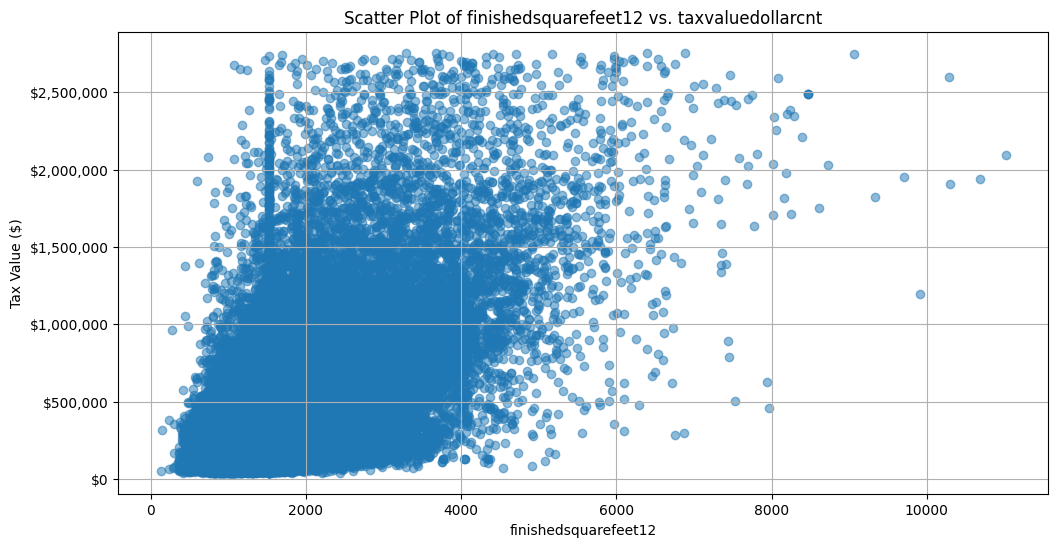

In [37]:
#Create 2D scatter plots or density plots to explore interactions between these features finishedsquarefeet12 x taxvaluedollarcnt
plt.figure(figsize=(12, 6))
plt.scatter(df_4['finishedsquarefeet12'], df_4['taxvaluedollarcnt'], alpha=0.5)
plt.title('Scatter Plot of finishedsquarefeet12 vs. taxvaluedollarcnt')
plt.xlabel('finishedsquarefeet12')
plt.ylabel('Tax Value ($)')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.grid()
plt.show()


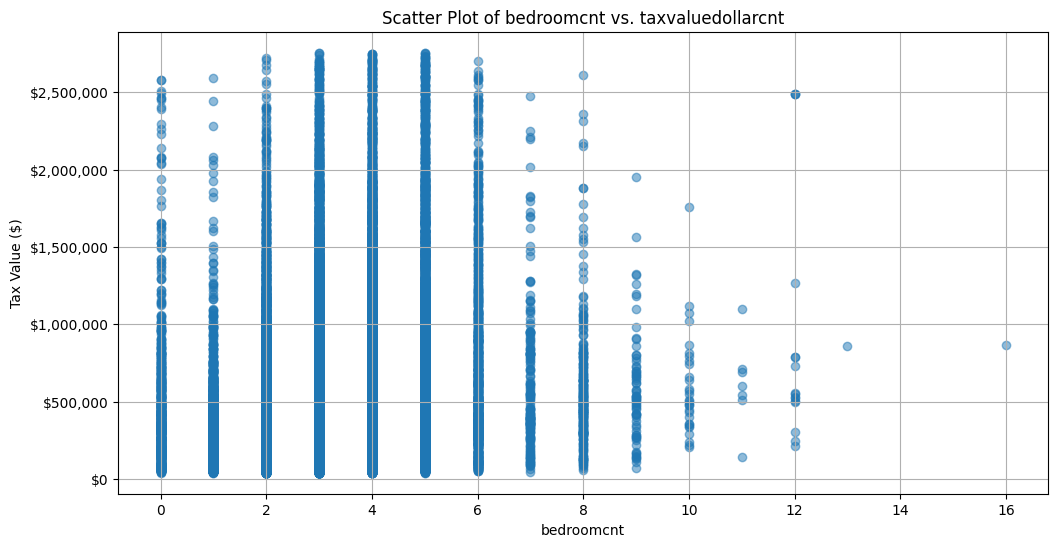

In [38]:
#Create 2D scatter plots or density plots to explore interactions between these features bedroomcnt x taxvaluedollarcnt
plt.figure(figsize=(12, 6))
plt.scatter(df_4['bedroomcnt'], df_4['taxvaluedollarcnt'], alpha=0.5)
plt.title('Scatter Plot of bedroomcnt vs. taxvaluedollarcnt')
plt.xlabel('bedroomcnt')
plt.ylabel('Tax Value ($)')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.grid()
plt.show()

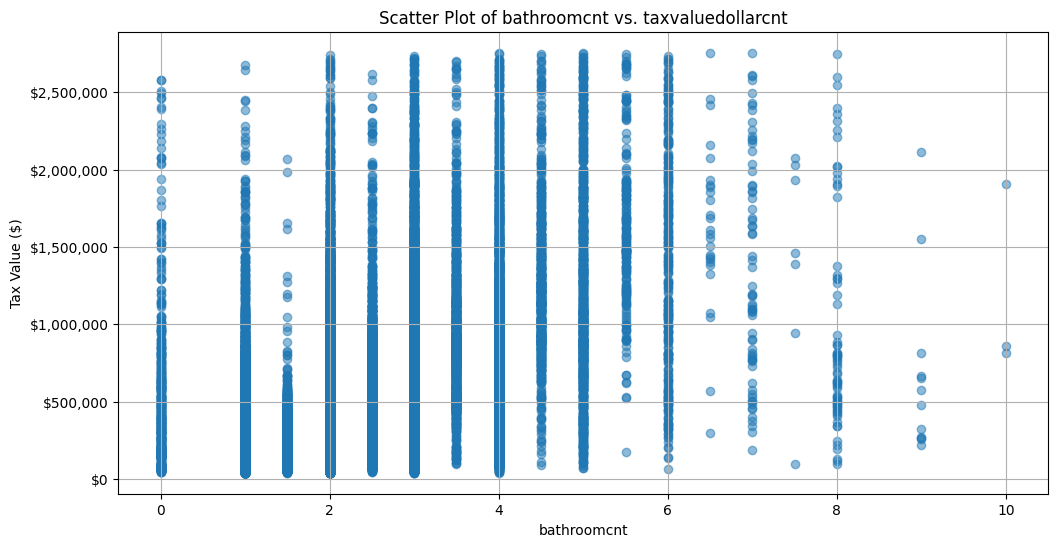

In [40]:
#Create 2D scatter plots or density plots to explore interactions between these features bathroomcnt x taxvaluedollarcnt
plt.figure(figsize=(12, 6))
plt.scatter(df_4['bathroomcnt'], df_4['taxvaluedollarcnt'], alpha=0.5)
plt.title('Scatter Plot of bathroomcnt vs. taxvaluedollarcnt')
plt.xlabel('bathroomcnt')
plt.ylabel('Tax Value ($)')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.grid()
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


From the scatter plot of finishedsquarefeet12 (property size in square feet) versus taxvaluedollarcnt (tax-assessed property value), a few patterns emerge: Dense Cluster: Most properties fall within the range of 0 to 4,000 square feet and 0 to 1,500,000 dollars, representing standard residential property sizes and values. Sparse Distribution: Properties with more extensive square footage and higher tax values, those exceeding 4,000 square feet and $ 1,500,000, are less frequent, suggesting the presence of luxury or premium property categories. Vertical Line at Approximately 1,000 Square Feet: A noticeable column of points around 1,000 square feet indicates a common property size; however, the tax values for these properties vary widely. Positive Correlation: Overall, there is a trend where larger properties tend to have higher tax values, although the relationship is not perfectly linear.

The scatter plot of bedroom count versus tax-valued dollar amount reveals several patterns: Concentration: Properties with 2 to 5 bedrooms dominate the dataset, indicating that these are the most common configurations.   Rising Trend: As the number of bedrooms increases, the tax value tends to grow, although the relationship is not entirely consistent. Wide Range for Common Bedroom Counts: Properties with 2 to 5 bedrooms exhibit significant variability in tax value, suggesting that other factors, such as location or square footage, may also influence valuation.   Rarity Beyond 10 Bedrooms: Homes with more than 10 bedrooms are less common but generally have higher tax values, suggesting they may belong to a niche luxury property market. These trends highlight the interplay between bedroom count and property valuation while also suggesting that other variables likely contribute to the observed variability. 



Based on the scatter plot of bathroom count versus tax-valued dollar amount, the following notable patterns are observed: Concentration at Common Bathroom Counts - Properties with 0, 2, 4, and 6 bathrooms appear most frequently, indicating these as standard configurations in the dataset. Low Tax Values for Homes with No Bathrooms: Homes with 0 bathrooms typically have tax values below $500,000, likely corresponding to more straightforward properties, such as undeveloped land or fundamental units. Tax Value Growth with Additional Bathrooms: Generally, as the number of bathrooms increases, the tax value tends to trend upward, reflecting the association between property size, luxury features, and valuation. High-Value Outliers for Larger Bathroom Counts: Properties with eight or more bathrooms are rare but tend to show high tax values, often exceeding $1,000,000, and likely represent luxury estates. These trends help illustrate how the number of bathrooms influences property valuation while also hinting at underlying factors, such as home size and location, that may be worth investigating further. 

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

Evaluating Log Transformation:
                            Feature  Correlation (Before/After)
0      calculatedfinishedsquarefeet                    0.575363
1                        bedroomcnt                    0.260655
2                         yearbuilt                    0.158634
3  calculatedfinishedsquarefeet_log                    0.531769
4                    bedroomcnt_log                    0.233994
5                     yearbuilt_log                    0.157324

Evaluating Standardization:
                               Feature  Correlation (Before/After)
0         calculatedfinishedsquarefeet                    0.575363
1                           bedroomcnt                    0.260655
2                            yearbuilt                    0.158634
3  calculatedfinishedsquarefeet_scaled                    0.575363
4                    bedroomcnt_scaled                    0.260655
5                     yearbuilt_scaled                    0.158634

Evaluating Polynomial 

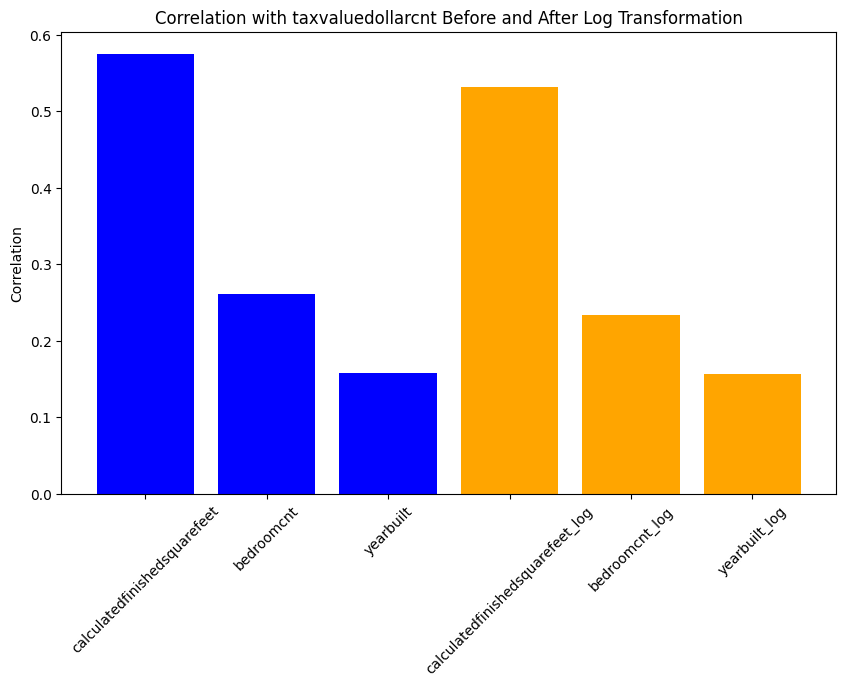

In [17]:
df_5 = df_cleaned_e.copy()

# Function 1: Logarithmic Transformation for Skewed Features
def apply_log_transformation(data, features):
    """Apply log(x + 1) transformation to handle skewness."""
    df_transformed = data.copy()
    for feature in features:
        df_transformed[f'{feature}_log'] = np.log1p(data[feature])  # log1p handles zeros
    return df_transformed

# Function 2: Feature Scaling (Standardization)
def standardize_features(data, features):
    """Standardize features to mean=0, std=1."""
    df_scaled = data.copy()
    scaler = StandardScaler()
    df_scaled[[f'{feat}_scaled' for feat in features]] = scaler.fit_transform(data[features])
    return df_scaled

# Function 3: Polynomial Features (Quadratic Terms) - FIXED
def add_polynomial_features(data, features):
    """Add quadratic (x^2) terms for selected features."""
    df_poly = data.copy()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(data[features])

    all_feature_names = poly.get_feature_names_out(features)
    quadratic_indices = [i for i, name in enumerate(all_feature_names) if '^2' in name]
    quadratic_names = [f'{feat}_squared' for feat in features]  
    df_poly[quadratic_names] = poly_features[:, quadratic_indices]  
    return df_poly


features_to_transform = ['calculatedfinishedsquarefeet', 'bedroomcnt', 'yearbuilt']
target = 'taxvaluedollarcnt'

# 1. Log Transformation
df_log = apply_log_transformation(df_5, features_to_transform)
log_features = [f'{feat}_log' for feat in features_to_transform]

# 2. Standardization
df_scaled = standardize_features(df_5, features_to_transform)
scaled_features = [f'{feat}_scaled' for feat in features_to_transform]

# 3. Polynomial Features (Fixed)
df_poly = add_polynomial_features(df_5, features_to_transform)
poly_features = [f'{feat}_squared' for feat in features_to_transform]


def evaluate_transformations(original_data, transformed_data, new_features, target):
    """Compute correlations with target before and after transformation."""
    correlations_before = original_data[features_to_transform].corrwith(original_data[target])
    correlations_after = transformed_data[new_features].corrwith(transformed_data[target])
    return pd.DataFrame({
        'Feature': features_to_transform + new_features,
        'Correlation (Before/After)': list(correlations_before) + list(correlations_after)
    })


print("Evaluating Log Transformation:")
log_eval = evaluate_transformations(df_5, df_log, log_features, target)
print(log_eval)

print("\nEvaluating Standardization:")
scaled_eval = evaluate_transformations(df_5, df_scaled, scaled_features, target)
print(scaled_eval)

print("\nEvaluating Polynomial Features:")
poly_eval = evaluate_transformations(df_5, df_poly, poly_features, target)
print(poly_eval)


plt.figure(figsize=(10, 6))
plt.bar(log_eval['Feature'], log_eval['Correlation (Before/After)'], color=['blue']*3 + ['orange']*3)
plt.xticks(rotation=45)
plt.title('Correlation with taxvaluedollarcnt Before and After Log Transformation')
plt.ylabel('Correlation')
plt.show()

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 

We selected logarithmic transformation, standardization, and polynomial (quadratic) features for calculatedfinishedsquarefeet, bedroomcnt, and yearbuilt to address skewness, scale differences, and potential non-linear relationships with taxvaluedollarcnt, informed by their variability and skewness in the EDA. The log transformation, intended to mitigate right-skewed distributions, unexpectedly reduced correlations (e.g., 0.575 to 0.532 for square footage, 0.261 to 0.234 for bedroom count), suggesting that compressing these features may obscure their linear relationship with the target, possibly due to over-normalization or a non-logarithmic pattern. Standardization, applied to ensure uniform scale for model compatibility, preserved correlations exactly (e.g., 0.575 unchanged), confirming it adjusts magnitude without altering linear relationships—useful but neutral here. Quadratic features, chosen to capture non-linear effects, lowered the correlation for square footage (0.575 to 0.406) but slightly improved it for yearbuilt (0.159 to 0.160) and bedroomcnt (0.261 to 0.246), hinting that squaring might dilute some relationships while subtly enhancing others. These results suggest that standardization is safest for now, while log and polynomial transformations need further tuning (e.g., different bases or interactions) or model-specific evaluation in Milestone 2 to unlock their potential.

Log Transformation:
- Observation: Correlations dropped (e.g., calculatedfinishedsquarefeet: 0.575 to 0.532).
- Interpretation: The log function may have over-corrected skewness, flattening variance too much, or the relationship with taxvaluedollarcnt isn’t logarithmic. This contrasts with expectations from the skewed EDA distribution.

Standardization:
- Observation: Correlations unchanged (e.g., 0.575 stays 0.575).
- Interpretation: As expected, standardization only shifts scale, not shape, making it a safe preprocessing step for models like regression or SVM without impacting feature-target relationships.

Polynomial Features:
- Observation: Mixed results—calculatedfinishedsquarefeet dropped (0.575 to 0.406), bedroomcnt slightly dropped (0.261 to 0.246), yearbuilt slightly rose (0.159 to 0.160).
- Interpretation: Quadratic terms weakened the strong linear signal in square footage, possibly indicating a more complex (e.g., cubic) or linear relationship dominates. Minor gains in yearbuilt suggest age might have a subtle non-linear effect worth exploring further.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

